# Monte Carlo Relaxation

In [1]:
from __future__ import print_function

In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt

In [3]:
import random, math

## Setup perfect system

In [4]:
from lammps import IPyLammps

In [5]:
L = IPyLammps()

LAMMPS output is captured by PyLammps wrapper


In [6]:
L.units("lj")
L.atom_style("atomic")
L.atom_modify("map array sort", 0, 0.0)

L.dimension(2)

L.lattice("hex", 1.0)
L.region("box block", 0, 10, 0, 5, -0.5, 0.5)

L.create_box(1, "box")
L.create_atoms(1, "box")
L.mass(1, 1.0)

L.pair_style("lj/cut", 2.5)
L.pair_coeff(1, 1, 1.0, 1.0, 2.5)
L.pair_modify("shift", "yes")

L.neighbor(0.3, "bin")
L.neigh_modify("delay", 0, "every", 1, "check", "yes")

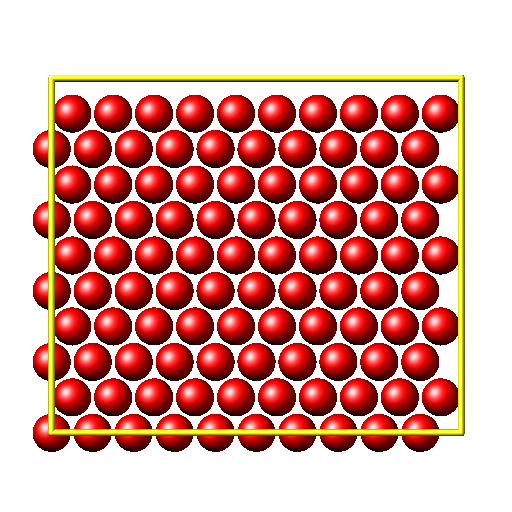

In [7]:
L.image(zoom=1.6)

In [8]:
L.run(0);

In [9]:
emin = L.eval("pe")

In [10]:
L.dump("3 all movie 25 movie.mp4 type type zoom 1.6 adiam 1.0")

## Disorder system

In [11]:
random.seed(27848)
deltaperturb = 0.2

In [12]:
for i in range(L.system.natoms):
    x, y = L.atoms[i].position
    dx = deltaperturb * random.uniform(-1, 1)
    dy = deltaperturb * random.uniform(-1, 1)
    L.atoms[i].position = (x+dx, y+dy)

In [13]:
L.run(0);

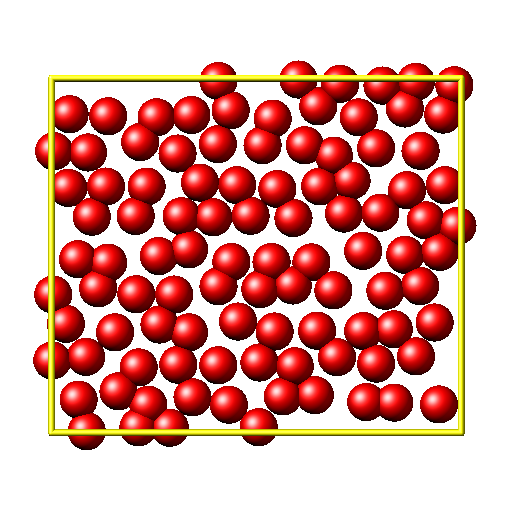

In [14]:
L.image(zoom=1.6)

## Minimize using Monte Carlo moves

In [15]:
estart = L.eval("pe")
elast = estart

In [16]:
naccept = 0

In [17]:
energies = [estart]

In [18]:
niterations = 3000
deltamove = 0.1
kT = 0.05

In [19]:
natoms = L.system.natoms

for i in range(niterations):
    iatom = random.randrange(0, natoms)
    current_atom = L.atoms[iatom]
    
    x0, y0 = current_atom.position
    
    dx = deltamove * random.uniform(-1, 1)
    dy = deltamove * random.uniform(-1, 1)
    
    current_atom.position = (x0+dx, y0+dy)
    
    L.run(1, "pre no post no")
    
    e = L.eval("pe")
    energies.append(e)
    
    if e <= elast:
        naccept += 1
        elast = e
    elif random.random() <= math.exp(natoms*(elast-e)/kT):
        naccept += 1
        elast = e
    else:
        current_atom.position = (x0, y0)

<IPython.core.display.Javascript object>


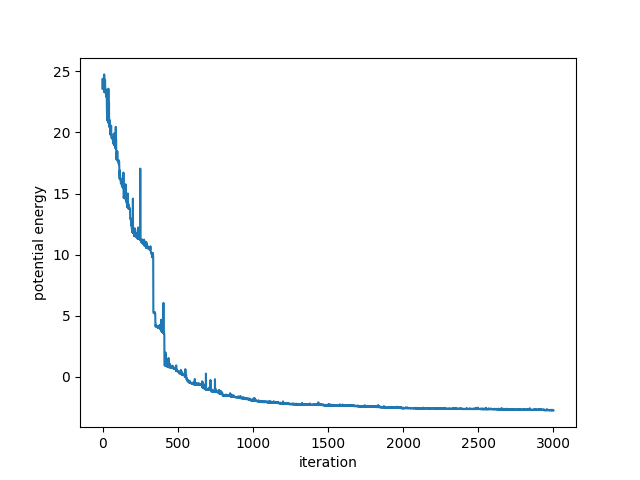

In [20]:
plt.xlabel('iteration')
plt.ylabel('potential energy')
plt.plot(energies)

In [21]:
L.eval("pe")

-2.7617330706844485

In [22]:
emin

-2.9871561644794546

In [23]:
estart

23.597375873270526

In [24]:
naccept

534

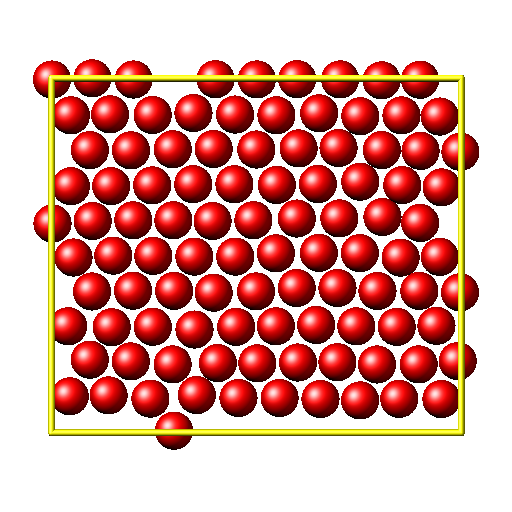

In [25]:
L.image(zoom=1.6)

In [26]:
# close dump file to access it
L.undump(3)

In [27]:
L.video("movie.mp4")